# Классификации комментариев для интернет-магазина


**Постановка задачи:**

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть, клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Небходимо:**

Обучить модель классифицировать комментарии на позитивные и негативные. Значение метрики качества `f1` у модели должно быть не меньше 0.75.

Данные находятся в файле `toxic_comments.csv`. Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Очистка-текста" data-toc-modified-id="Очистка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Очистка текста</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Количество-символов-тексте" data-toc-modified-id="Количество-символов-тексте-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Количество символов тексте</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных" data-toc-modified-id="Разделение-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделение данных</a></span></li><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#BernoulliNB" data-toc-modified-id="BernoulliNB-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>BernoulliNB</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Загрузка и подготовка данных

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import spacy
import warnings

from catboost import CatBoostClassifier
from functools import reduce
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', 500)

Прочитаем файл `toxic_comments.csv` из папки `datasets` и сохраним его в переменной `df`:

In [4]:
try:
    PATH = 'datasets/'
    df = pd.read_csv(os.path.join(PATH, 'toxic_comments.csv'))
    print('Прочитали файл путь:', PATH)
except:
    print('У нас проблема')

Прочитали файл путь: datasets/


Выведем на экран первые 5 строк таблицы `df`:

In [5]:
df.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Получим общую информацию о таблице:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим на пропуски:

In [7]:
df.isna().sum()

text     0
toxic    0
dtype: int64

В таблице 2 колонки, 159_571 строк. Тип данных в столбцах: object, int64. Пропущенных значений нет

### Очистка текста

Начнем с предобработки текста. Оставим только слова, состоящие из букв, c помощью функции `text_clean_func`

In [8]:
def text_clean_func(text):
    text = text.lower()
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"'re", " are ", text)
    text = re.sub(r"'ll", " will ", text)
    text = re.sub("[^a-z]", " ", text)
    text = re.sub("\s+", " ", text)
    text = text.strip(' ')
    return text

In [9]:
%%time
df['text_clean'] = df['text'].apply(text_clean_func)

CPU times: user 6.26 s, sys: 20.4 ms, total: 6.28 s
Wall time: 6.28 s


Посмотрим на результат очистки текста:

In [10]:
df[['text', 'text_clean']].head()

,text,text_clean
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",explanation why the edits made under my username hardcore metallica fan were reverted they weren not vandalisms just closure on some gas after i voted at new york dolls fac and please don not remove the template from the talk page since i am retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",d aww he matches this background colour i am seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",hey man i am really not trying to edit war it is just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,more i can not make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it is listed in the relevant form eg wikipedia good article nominations transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",you sir are my hero any chance you remember what page that is on


### Лемматизация

Приведём слова в комментариях к их началой форме, лемме, с помощью библиотеки `spacy`

Напишем функцию `text_lemm_func` для лемматизации текста:

In [11]:
disabled_pipes = ['parser',  'ner']
nlp = spacy.load('en_core_web_sm', disable=disabled_pipes)
def text_lemm_func(row):
    doc = nlp(row)
    words = [token.lemma_ for token in doc]
    lemm_row = ' '.join(words)
    return lemm_row

In [12]:
%%time
df['text_lemm'] = df['text_clean'].apply(text_lemm_func)

CPU times: user 9min 38s, sys: 11.8 s, total: 9min 50s
Wall time: 9min 50s


Посмотрим на результат лемматизации:

In [13]:
df[['text_clean', 'text_lemm']].sample(3)

,text_clean,text_lemm
24942,my selections though this list needs further paring down just as koch inherited his oil business from his father americans for prosperity borrows from the ultra right group also founded in part by his dad the john birch society conceived by robert welch and a small group of conservative industrialists including fred koch david is father and the namesake of the family firm of koch industries the john birch society cloaked its pro business anti civil rights agenda in the rhetoric of the cold war cushioned with large donations from koch and others the birch society helped propel barry goldwater to the republican nomination in and helped republicans make gains in the congressional midterms of like americans for prosperity the john birch society rarely acknowledged its funding from the very rich instead it depicted itself as a citizens group merely interested in american ideals of freedom rather than argue the policy nuances of entitlement programs or new regulations the birch society m...,my selection though this list need far pare down just as koch inherit his oil business from his father americans for prosperity borrow from the ultra right group also found in part by his dad the john birch society conceive by robert welch and a small group of conservative industrialist include fred koch david be father and the namesake of the family firm of koch industry the john birch society cloak its pro business anti civil right agenda in the rhetoric of the cold war cushion with large donation from koch and other the birch society help propel barry goldwater to the republican nomination in and help republicans make gain in the congressional midterm of like americans for prosperity the john birch society rarely acknowledge its funding from the very rich instead it depict itself as a citizen group merely interested in american ideal of freedom rather than argue the policy nuance of entitlement program or new regulation the birch society marshal opposition by depict progressive ...
76615,on frank do you listen to that station every single day,on frank do you listen to that station every single day
86703,i am sorry i am sorry for the vandalizim i have done but what i wrote is true,I be sorry I be sorry for the vandalizim I have do but what I write be true


In [14]:
df['text_clean'] = df['text_clean'].astype('U')
df['text_lemm'] = df['text_lemm'].astype('U')

### Количество символов тексте

Добавим признак с количеством символов в тексте

In [15]:
df['length'] = df['text_lemm'].apply(len)

Посмотрим на распределение длинны текста в наших данных

In [16]:
def histplot_boxplot(df, column, bins=50):
    """
    df - датафрейм
    column - название признака для построения графиков
    bins - количество корзин (50 по умолчанию)
    
    """
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.13, .87)},
                                        figsize=(12, 8))
    sns.boxplot(data=df, 
                x=column,  
                orient='h',
                order=[1,0],
                palette='pastel',
                ax=ax_box)
    sns.histplot(data=df, 
                 x=column, 
                 bins=bins, 
                 kde=True, 
                 palette='pastel', 
                 hue_order=[1,0],
                 ax=ax_hist)
 
    ax_box.set(xlabel='')
    ax_box.set(title='Ящик с усами для "{}"'.format(column))
    ax_hist.set(title='Распределение признака "{}"'.format(column))
    plt.show()

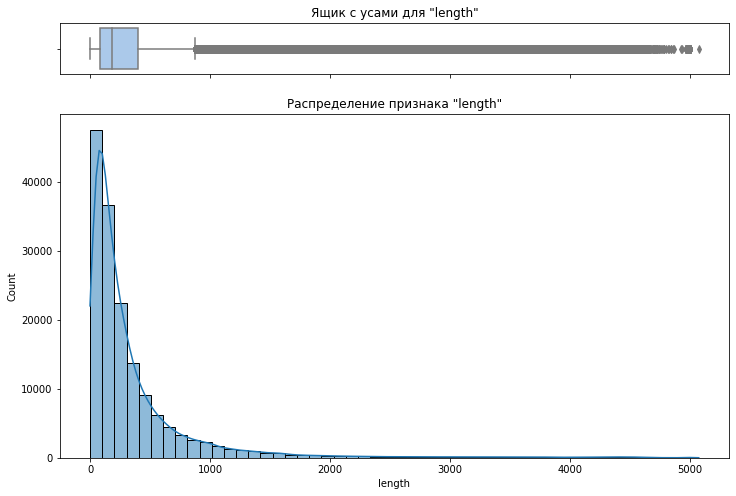

In [17]:
histplot_boxplot(df, 'length')

Посмотрим на комментарии с количеством символов меньше 10:

In [18]:
df.query('length <= 10').sort_values(by='length', ascending=False)

,text,toxic,text_clean,text_lemm,length
29508,I think so. 222.35.87.233,0,i think so,I think so,10
109075,""":* Fixed that. (T) \n""",0,fixed that t,fix that t,10
37699,"""\nSounds good.— (竜龍) """,0,sounds good,sound good,10
75860,") 11:30, 24 August 2009 (UTC",0,august utc,august utc,10
78243,"""\nSounds good. ♦ ♣ ♠ """,0,sounds good,sound good,10
...,...,...,...,...,...
61758,"""\n\n 199.209.144.211 """,0,,,0
53787,92.24.199.233|92.24.199.233]],0,,,0
82681,"""\n '''''' 2010/2013 """,0,,,0
52442,"14:53,",0,,,0


In [19]:
print('Количесво комментариев с 0 символами:', len(df.query('length == 0')))

Количесво комментариев с 0 символами: 7


Посмотрим на самые длинные комментарии:

In [20]:
df[['text_clean', 'length']].sort_values(by='length', ascending=False).head(3)

,text_clean,length
82636,muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahahahahahahahahahahahahaha you can not stop my vandalism muahahahahahahah...,5072
27148,damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn you u cunt damn...,5000
93952,wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki noobs wiki n...,5000


Видим проблему наличия сверхдлинных слов, а также множества повторяющихся слов в одном сообщении

## Обучение моделей

### Разделение данных

Зафиксируем параметр псевдослучайности для наших моделей и выборок:

In [21]:
rnd_st = 12345

Разделим исходные данные на обучающую `train` и тестовую выборки `test`:

In [22]:
X = df['text_lemm']
y = df['toxic'] 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [24]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

111699 111699
47872 47872


### Баланс классов

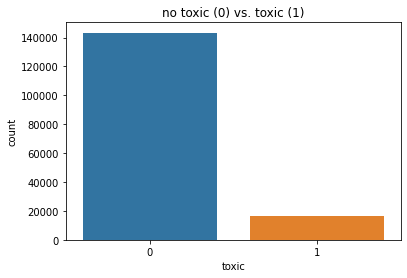

In [25]:
sns.countplot(data = df, x='toxic')
plt.title('no toxic (0) vs. toxic (1)')
plt.show()

In [26]:
y.value_counts(normalize=True).map('{:.2%}'.format)

0    89.83%
1    10.17%
Name: toxic, dtype: object

Классы неслабансированы: соотношение 9 к 1

### LogisticRegression

Напишем функцию `grid_search_func` для проведения поиска по решетке, вывода лучших параметров модели и метрики. Функция будет возвращать лучший оценщик

In [27]:
def grid_search_func(model, parameters, features_train, target_train):
    """
    model - модель
    param_grid - параметры для поиска по решетке
    features_train - входные признаки обучающая выборка
    target_train - входные признаки тестовая выборка
    
    """
    gs = GridSearchCV(estimator=model, param_grid=parameters, 
                      scoring='f1', cv=3, verbose=0)
    gs.fit(features_train, target_train)
    gs_best_estimator = gs.best_estimator_
    print('Best parameters:', gs.best_params_)
    print('Best f1 = %.4f' % abs(gs.best_score_))
    return gs_best_estimator

Объединим операции обработки данных в конвейер `pipe`: `TF-IDF` векторизатор и Логистическая регрессия:

In [28]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
logreg_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('logreg', LogisticRegression(random_state=rnd_st, class_weight='balanced'))
])
    
param_grid = {
    'logreg__C': [10],
#    'logreg__C': [1, 3, 5, 10, 20],
    'tfidf__ngram_range': [(1, 3)],
#    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df': [2]
#    'tfidf__min_df': [1, 2, 3]
}

In [30]:
%%time
logreg_gs_best_estimator = grid_search_func(logreg_pipe, param_grid, X_train, y_train)

Best parameters: {'logreg__C': 10, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Best f1 = 0.7736
CPU times: user 6min 5s, sys: 1min 8s, total: 7min 13s
Wall time: 1min 24s


### LinearSVC

Объединим операции обработки данных в конвейер `pipe`: `TF-IDF` векторизатор и LinearSVC:

In [31]:
lin_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('lin_svc', LinearSVC(random_state=rnd_st, class_weight='balanced'))
])
    
param_grid = {
    'lin_svc__C': [0.7],
#     'lin_svc__C': [0.5, 0.7, 1]
    'tfidf__ngram_range': [(1, 3)],
    'tfidf__min_df': [2]
}

In [32]:
%%time
lin_svc_gs_best_estimator = grid_search_func(lin_svc_pipe, param_grid, X_train, y_train)

Best parameters: {'lin_svc__C': 0.7, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Best f1 = 0.7731
CPU times: user 1min, sys: 1.32 s, total: 1min 1s
Wall time: 1min 1s


### BernoulliNB

Объединим операции обработки данных в конвейер `pipe`: `TF-IDF` векторизатор и Бернулли Наивный баесовский классификатор:

In [33]:
bernulli_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('bernulli', BernoulliNB())
])

param_grid = {
    'bernulli__alpha': [0.25],
#    'bernulli__alpha': np.arange(0.1, 0.3, 0.05),
    'tfidf__ngram_range': [(1, 3)],
    'tfidf__min_df': [2]
} 

In [34]:
%%time
bnb_gs_best_estimator = grid_search_func(bernulli_pipe, param_grid, X_train, y_train)

Best parameters: {'bernulli__alpha': 0.25, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Best f1 = 0.4306
CPU times: user 54.4 s, sys: 1.15 s, total: 55.6 s
Wall time: 55.6 s


**Вывод:**

Модель-победитель на обучающей выборке с кросс-валидацией cv=5: логистическая регрессия с f1 = 0.7805

## Анализ моделей

Создадим таблицу `results` для хранения результатов:

In [35]:
data = {'model_name': [], 'f1': []}
results = pd.DataFrame(data=data)

Напишем функцию `model_result` проверки качества моделей на тестовой выборке и добавления результатов в общую таблицу результатов:

In [36]:
def model_result(comment, model, X_train, X_test, y_train, y_test):
    """
    comment - комментарий в таблицу
    model - модель
    X_train - входные признаки обучающая выборка
    X_test - входные признаки тестовая выборка
    y_train - целевой признак обучающая выборка
    y_test - целевой признак тестовая выборка
    
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    results.loc[len(results)] = [comment, f1]
    results.drop_duplicates(subset=['model_name'], inplace=True)

Добавим в таблицу результатов константную модель:

In [37]:
dict1 = {
    'LogisticRegression': logreg_gs_best_estimator,
    'Dummy_stratified': DummyClassifier(strategy='stratified')
}

In [38]:
for comment, model in dict1.items():
    model_result(comment, model, X_train, X_test, y_train, y_test)

Результаты на тестовой выборке:

In [39]:
results

,model_name,f1
0,LogisticRegression,0.790589
1,Dummy_stratified,0.106963


На тестовой выборке LogisticRegression `f1` = 0.790589

Посмотрим на матрицу ошибок логистической регрессии:

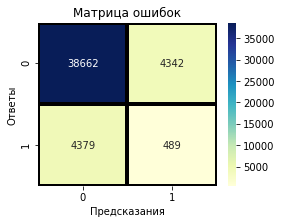

In [42]:
logreg_gs_best_estimator.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)    
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', linewidths=3, cmap='YlGnBu', linecolor='black')
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.title('Матрица ошибок')
plt.show()

Видим большое количества ложноотрицательных ответов (FN) и ложноположительных ответов (FP). Ложноотрицательные ответы ведут к уменьшению полноты, которая негативно влияет на f1 метрику. Ложноположительные ответы ведут к уменьшению точности, которая негативно влияет на f1 метрику

## Выводы


Обучили несколько моделей на классификацию комментариев пользователей.

`f1` на тестовой выборке для лучшей модели составляет 0.790589, что является достаточным для выполнения поставленной задачи